## Description

This jupyter notebook aims to reproduce **Fig 7** from Section 4.2 of the manuscript and its respective figures in the supplementary material.

To analyze the interactions between Atlantic and Pacific modes of internal variability without external forcing, we utilized a 250-year segment from the CESM2 pre-industrial control run. This dataset represents conditions prior to 1850 and was used to extract monthly averages for key variables including TS (surface temperature), SLP (sea level pressure), and U (wind).

The PCMCI+ causal graphs are produced for specific phase combinations based on the sign of the low-pass filtered (13-year Lanczos) time series of PDV (Pacific Decadal Variability) and AMV (Atlantic Multidecadal Variability).

We use the same indices for the causal analysis as in section4_obs_reanalysis.ipynb (**TNA**,**Niño3.4**,**ATL3**,**PNA**,**NAO**,**PWCu**) but calculated from:

- **CESM2 Pre-industrial Control run**


| **Index**         | **Definition**             | **Region**                                      |
|---------------|-------------------------------------------------------|---------------------------------------------|
| **TNA**           | Area-weighted monthly SSTAs over the North Tropical Atlantic region              | 5.5–23.5°N, 58°–15°W                       |
| **Niño3.4**      | Area-weighted monthly SSTAs over the equatorial Pacific region                       | 5°N–5°S, 170°–120°W                         |
| **PNA**           | Leading EOF of (3-monthly averaged and area-weighted) SLP anomalies over the Pacific North America region | 20–85°N, 120°E–120°W     |
| **NAO**           | Leading EOF of (3-monthly averaged and area-weighted) SLP anomalies over the North Atlantic region | 20–80°N, 90°W-40°E         |
| **PWCu**     | Monthly zonal wind anomaly at 925 hPa  (or nearest available level) over the equatorial Pacific region             | 6°N–6°S, 180°-150°E  |
| **ATL3**          | Area-weighted monthly SSTAs over the equatorial Atlantic region                   | 3°N–3°S, 20°W–0°                            |
| AMV           | Monthly SSTAs averaged over the North Atlantic region                                 | 0–60°N, 80–0°W                             |
| PDV           | PC associated with 1st EOF of area-weighted monthly SSTAs over the North Pacific region| 20–70°N, 110°E–100°W                      |

## I. Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings while loading
import numpy as np
from utils import Utils as utils
from data_visualization import DataVisualization as viz
import xarray as xr
import pickle
from run_causal_analysis import run_picontrol as rpic

## II. Settings and Parameters

In [2]:
min_tau,max_tau=0,4
var_names=['$TNA$','$PNA$','$Nino34$','$PWC_{u}$','$NAO$','$ATL3$']#
pc_alpha=0.05

FIGS_DIR="FIGS/PiControl/"
DF_DIR="DATA/PiControl/"
viz.create_directories(FIGS_DIR,DF_DIR)


Directory 'FIGS/PiControl/' already exists!
Directory 'DATA/PiControl/' already exists!


## III. Load datasets, calculate indices and prepare dataframe

#### **! Adjust path to data and file names accordingly !**

In [3]:
peeriood=['0400-01-15','1199-12-15']
peerioodpsl=['0400-01-01','1199-12-01']

ds_psl_pic=xr.open_dataset('/work/bd1083/b380749/b380749/NetCDF/psl_Amon_CESM2_piControl_r1i1p1f1_gn_merged.nc').sel(time=slice(peeriood[0],peeriood[1]))
ds_ts_pic=xr.open_dataset('/work/bd1083/b380749/b380749/NetCDF/ts_Amon_CESM2_piControl_r1i1p1f1_gn_merged.nc').sel(time=slice(peeriood[0],peeriood[1]))
ds_ua_pic=xr.open_dataset('/work/bd1083/b380749/b380749/NetCDF/ua_Amon_CESM2_piControl_r1i1p1f1_gn_merged.nc').sel(plev=92500).sel(time=slice(peeriood[0],peeriood[1]))

amv_pic_dict,pdv_pic_dict,tig_data_pic = rpic.load_calc_piControl(ds_ts_pic=ds_ts_pic,ds_psl_pic=ds_psl_pic,ds_ua_pic=ds_ua_pic,peeriood=peeriood,peerioodpsl=peerioodpsl)
    
np.save(file=DF_DIR+'data_picontrol_0400_1199.npy', arr=tig_data_pic)
with open(DF_DIR+'amv_pic_dict.pickle', 'wb') as handle:
    pickle.dump(amv_pic_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(DF_DIR+'pdv_pic_dict.pickle', 'wb') as handle:
    pickle.dump(pdv_pic_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [3]:
tig_data_pic=np.load(DF_DIR+'data_picontrol_0400_1199.npy')

with open(DF_DIR+'amv_pic_dict.pickle', 'rb') as file:
    amv_pic_dict = pickle.load(file)
with open(DF_DIR+'pdv_pic_dict.pickle', 'rb') as file:
    pdv_pic_dict = pickle.load(file)

### Plot AMV and PDV and make regime masks
Masks for:
- PDV+|AMV+ : when both AMV and PDV are positive
- PDV+|AMV- : when AMV is negative and PDV is positive
- PDV-|AMV+ : when AMV is positive and PDV is negative
- PDV-|AMV- : when both AMV and PDV are negative

In [4]:
window = 50
# construct low pass filters
hfw = utils.low_pass_weights(window, 1. / 51.)
weight_high = xr.DataArray(hfw, dims = ['window'])

T, N = tig_data_pic.shape
pdv=pdv_pic_dict['pdv_timeseries'].resample(time='QS-DEC', keep_attrs=True).mean()[1:]

pdv_lp=pdv.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
amv=amv_pic_dict['amv_timeseries'].resample(time='QS-DEC', keep_attrs=True).mean()[1:]
amv_lp=amv.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)

regime_masks_dict= rpic.make_regime_dict(amv_lp,pdv_lp,T,N)

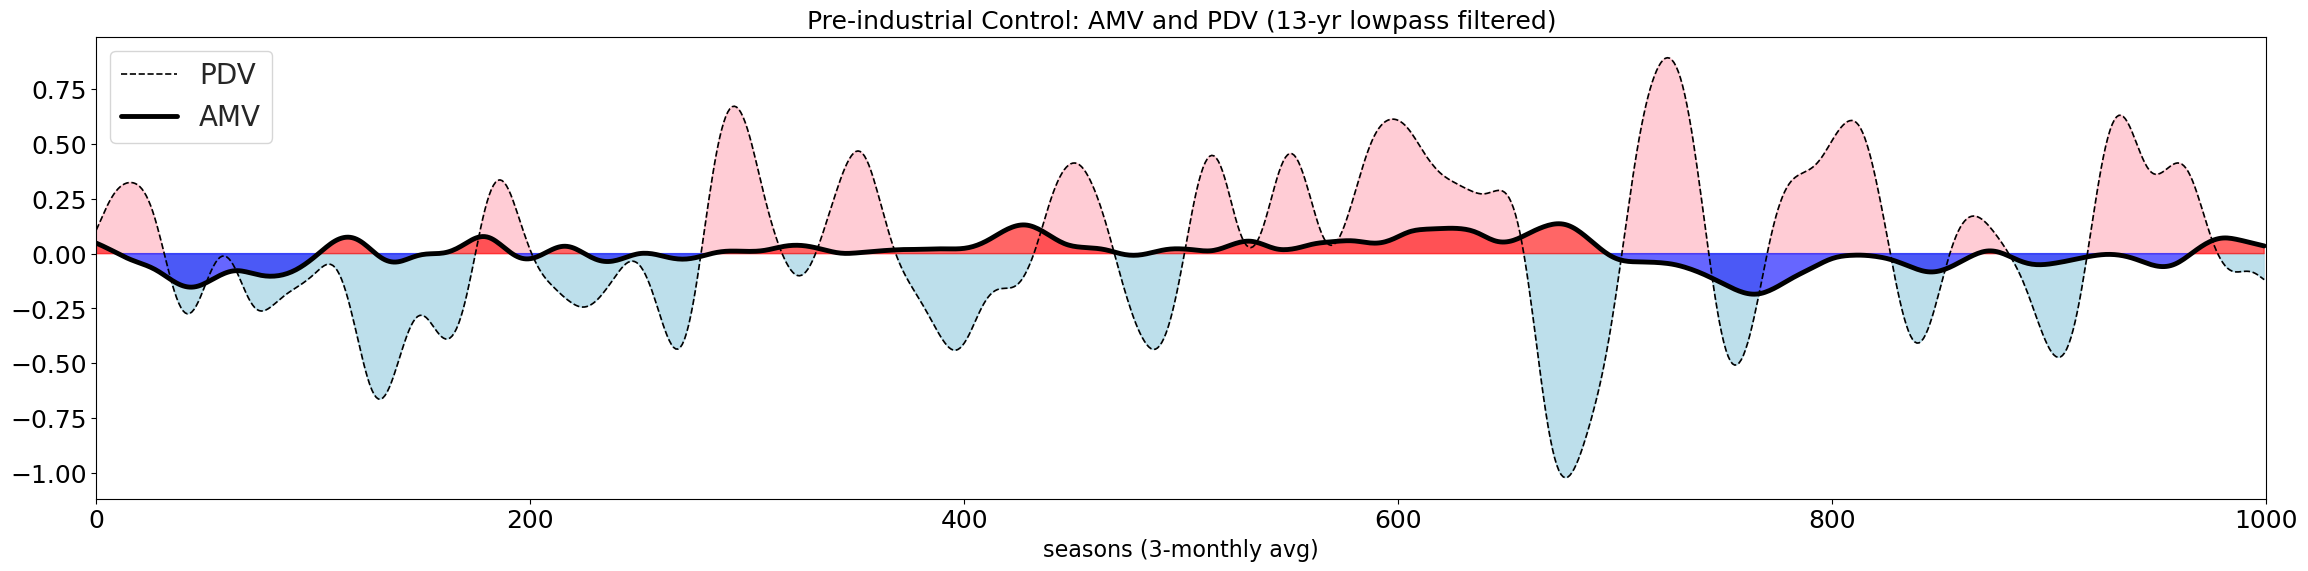

In [5]:

pdv_lp_short=pdv_lp.copy()[1000:2000]
amv_lp_short=amv_lp.copy()[1000:2000]

viz.plot_picontrol_amv_pdv(amv_lp=amv_lp_short,pdv_lp=pdv_lp_short,save_dir=FIGS_DIR)


## IV. Run PCMCI+ on masked data


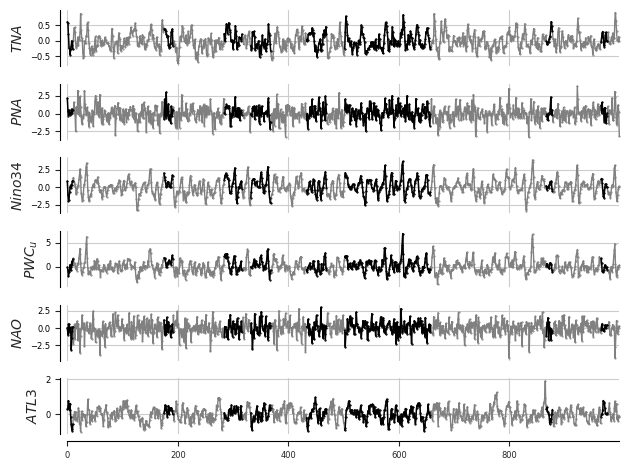

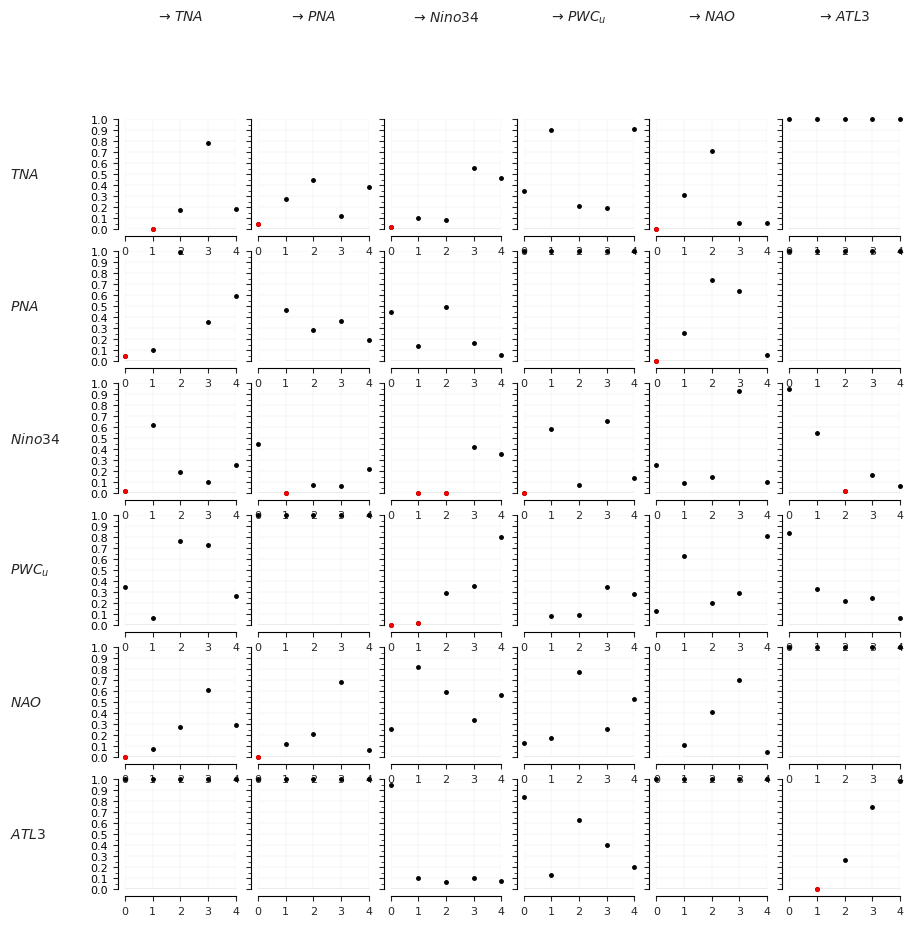

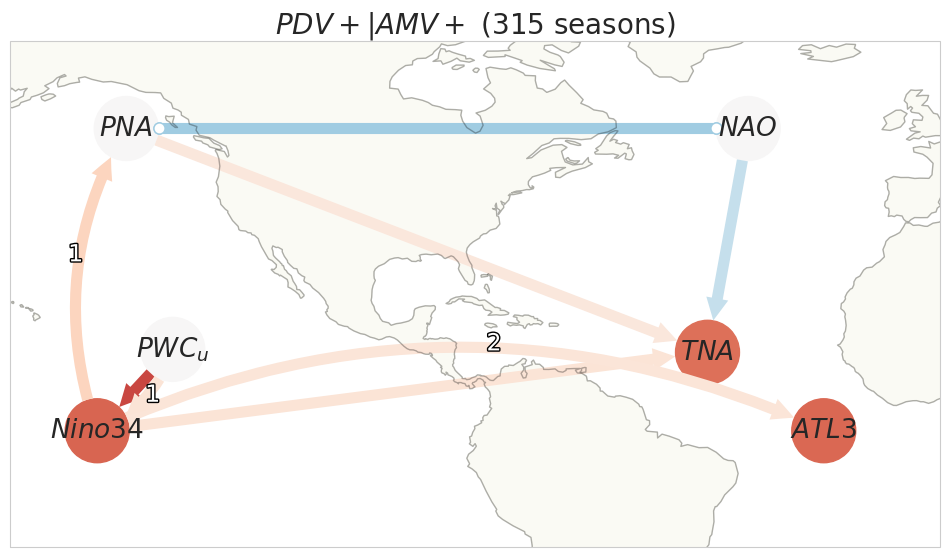

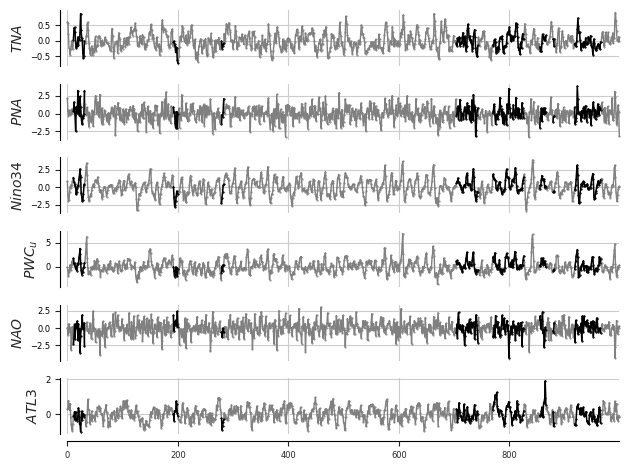

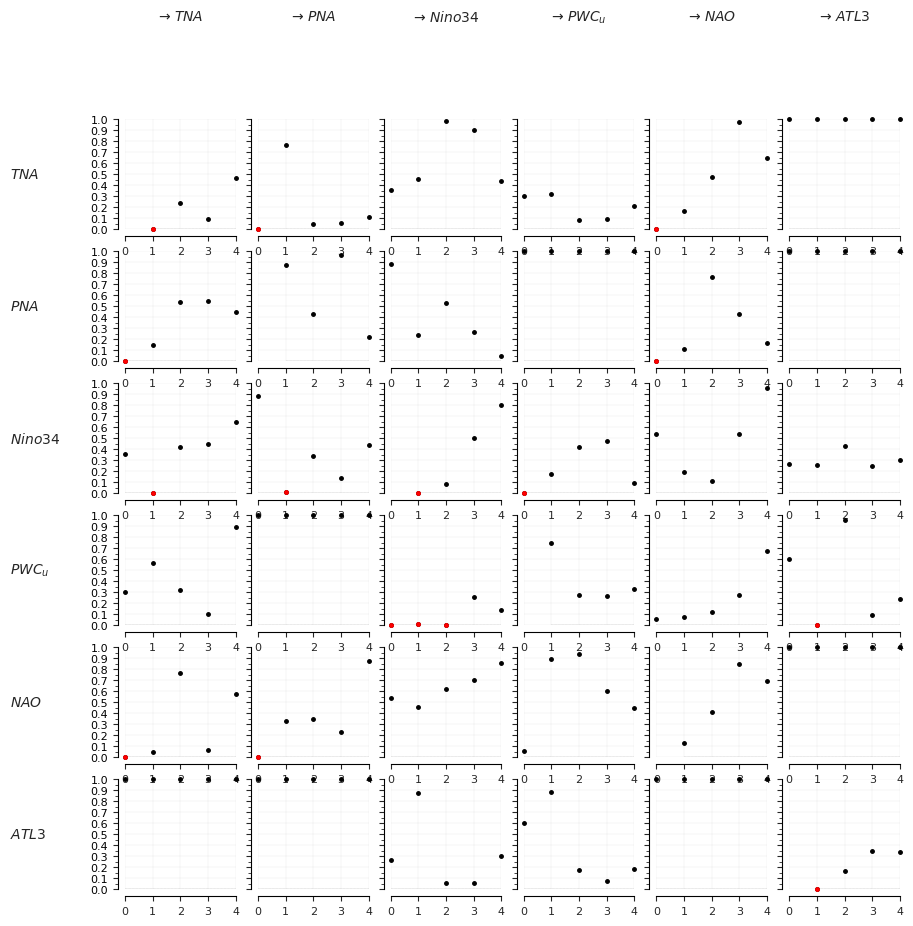

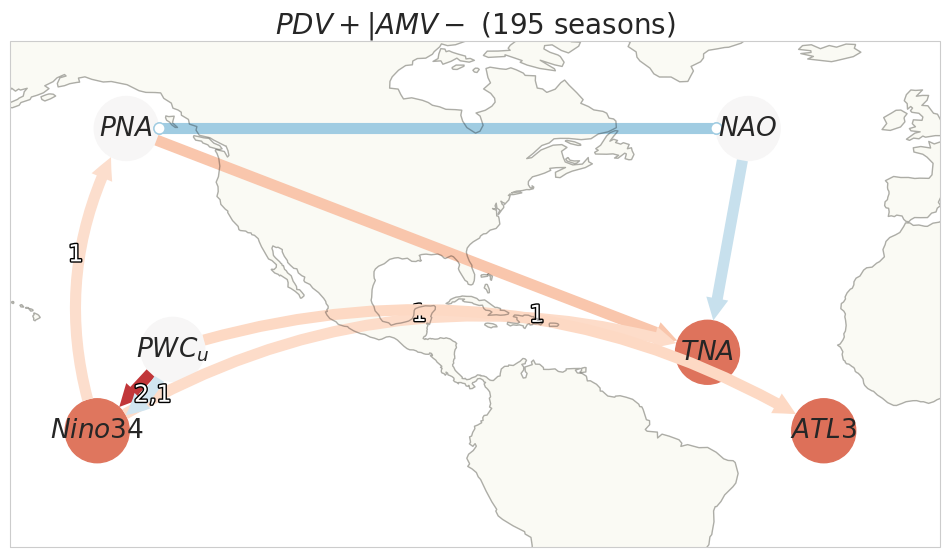

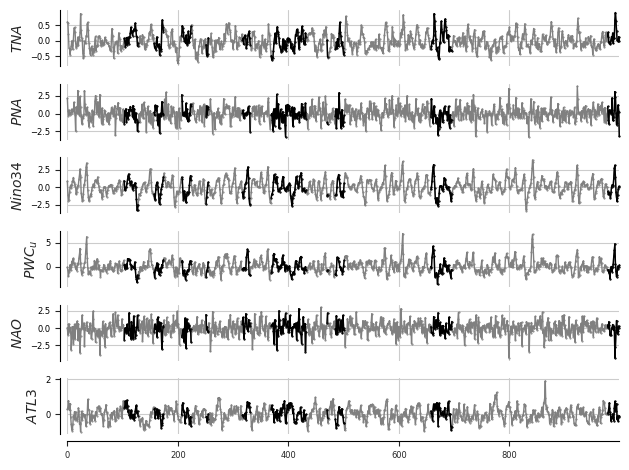

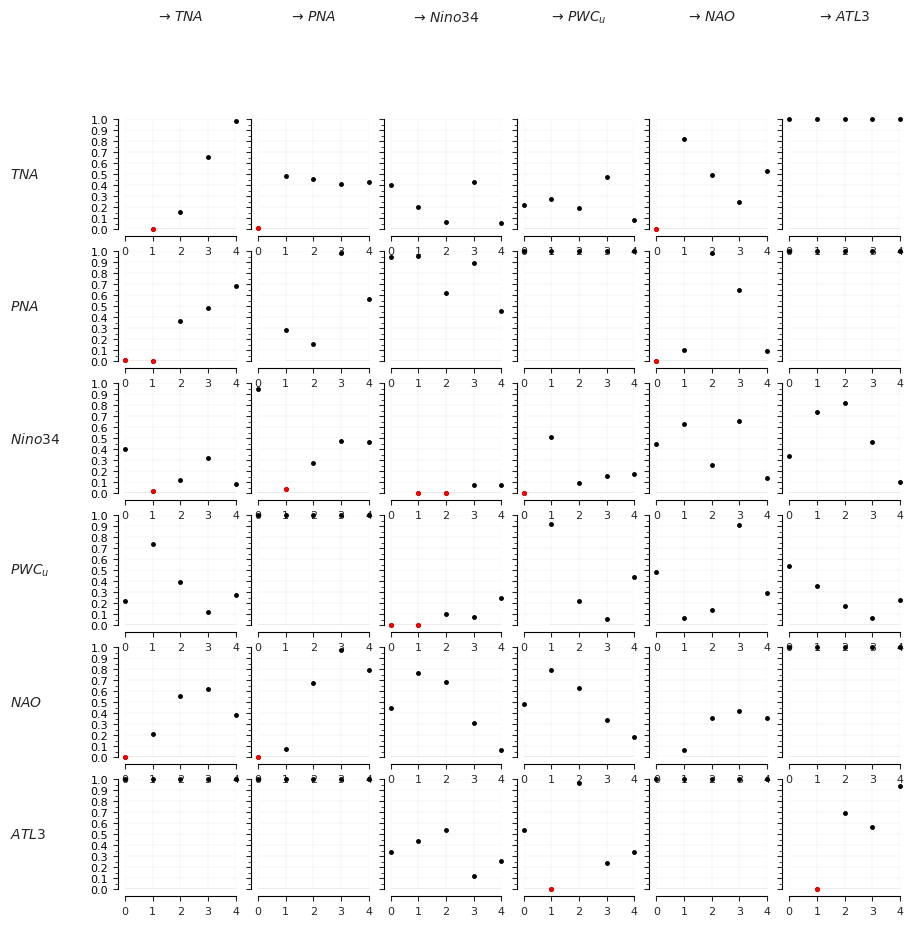

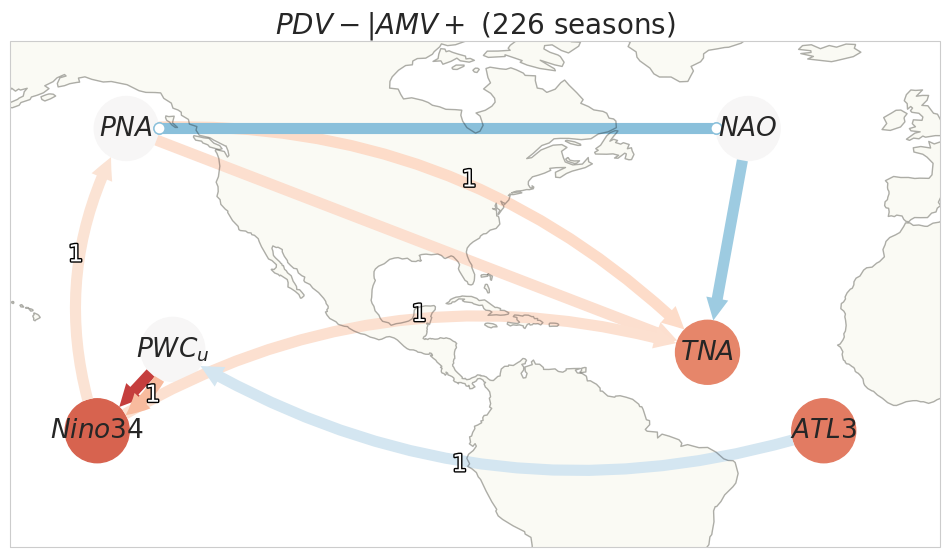

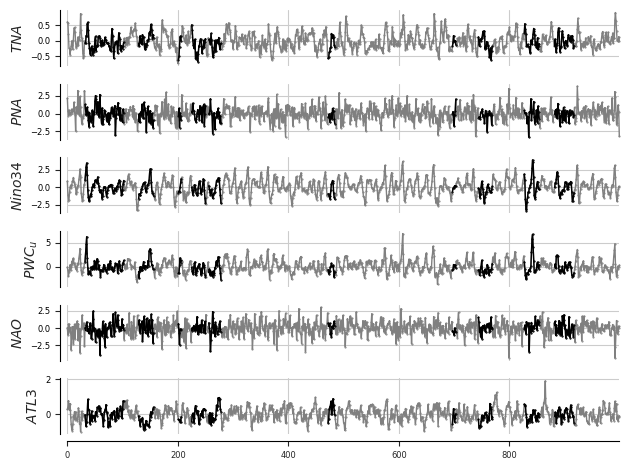

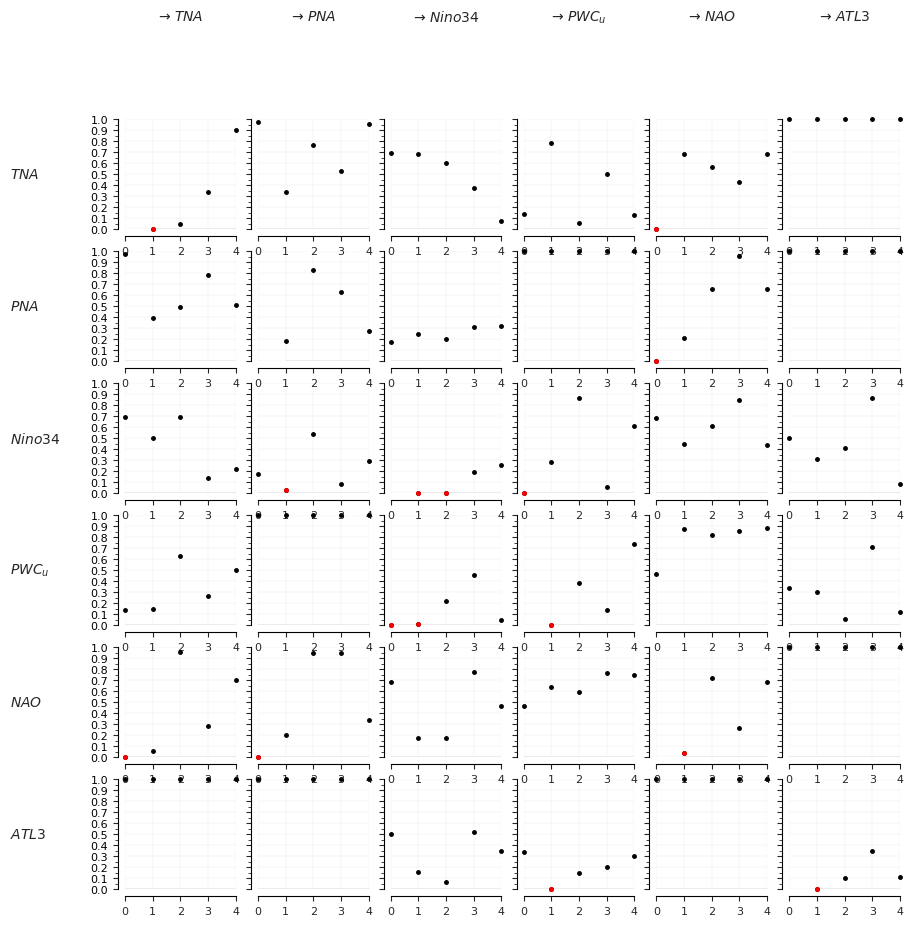

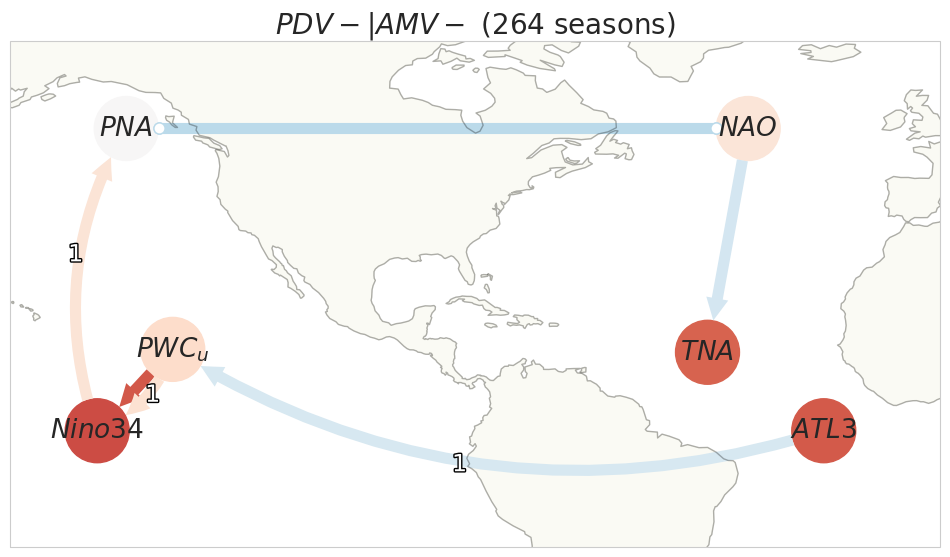

In [6]:
exp_data = tig_data_pic[1000:2000]
T, N = exp_data[:,:].shape

for k, regime in enumerate(regime_masks_dict.keys()):            
    rpic.run_regime_masked_pcmciplus(regime=regime, exp_data=exp_data, var_names=var_names, regime_masks_dict=regime_masks_dict,
                                     min_tau=min_tau, max_tau=max_tau, pc_alpha=pc_alpha, figs_dir=FIGS_DIR, scenario_id=k, link_assumption=True)
    